# Acoustic Source Localisation (ASL)

In [352]:
# Configuration

# NAME_EVALUATION = 'mean-err-n-sources'
# NAME_EVALUATION_OTHER = 'mean-err-n-sources-sample3and5exchanged'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-04*.txt'  # first trials, original speech samples

# NAME_EVALUATION = 'mean-err-n-sources-sample3and5exchanged'
# NAME_EVALUATION_OTHER = 'mean-err-n-sources-rnd'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-11*.txt'  # second trials, rearranged speech samples

NAME_EVALUATION = 'mean-err-n-sources-rnd'
NAME_FOLDER = "{}sources-rnd"
NAME_DATA_FILES = '2017-*results.txt'  # third trials, randomized speech samples

EXPORT_LATEX = False
EXPORT_RESULTS = True

In [421]:
%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as _tikz_save

pd.set_option('display.precision',3)

NAME_SCATTER_PLOT = NAME_EVALUATION+'-scatter.tex'
NAME_BOX_PLOT = NAME_EVALUATION+'-box.tex'
NAME_BAR_PLOT = NAME_EVALUATION+'-bar.tex'
NAME_SUMMARY_TABLE = NAME_EVALUATION+'-summary.tex'
NAME_PERFECT_MATCHES_PLOT = NAME_EVALUATION+'-perfect-matches-bar.tex'
NAME_DATAFRAME = NAME_EVALUATION+'-dataframe.pkl'
NAME_DATAFRAME_OTHER = NAME_EVALUATION_OTHER+'-dataframe.pkl'

PATH_ROOT = '../matlab/mainczjs/evaluation/results/'
PATH_LATEX_PLOTS = '../latex/data/plots/'
PATH_LATEX_TABLES = '../latex/data/tables/'

PATH_SCATTER_PLOT = path.join(PATH_LATEX_PLOTS, NAME_SCATTER_PLOT)
PATH_BOX_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BOX_PLOT)
PATH_BAR_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BAR_PLOT)
PATH_LATEX_SUMMARY_TABLE = path.join(PATH_LATEX_TABLES, NAME_SUMMARY_TABLE)

lms_red = (204/255, 53/255, 56/255)

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

def tikz_save(*args, **kwargs):
    """Wrapper for tikz_save function, that always suppresses additional info output"""
    kwargs['show_info'] = False 
    _tikz_save(*args, **kwargs)

def adjust_y_axis(step_size, digits=0, min=None):
    start, end = plt.axes().get_ylim()
    if min==None: min=start
    plt.yticks(np.arange(min, round(end+step_size, digits), step_size))

def style_boxplot(boxplots, fig=None, axes=None):
    if not type(boxplots)==type([]): boxplots=[boxplots]
    if not fig: fig = boxplots[0][0].ax.get_figure()
    if not axes: axes = [boxplots[0][0].ax]
    for bp in boxplots:
        for key in bp[0].lines.keys():
            for item in bp[0].lines[key]:
                if key=="fliers":
                    item.set_markerfacecolor("lightgray")
                    item.set_markeredgewidth(0)
                    item.set_markeredgecolor(lms_red)
                    item.set_markersize(7)
                if key=="medians":
                    item.set_color(lms_red)
                    item.set_linewidth(3)
                if key=="whiskers" or key=="caps":
                    item.set_color("gray")
                else:
                    item.set_color(lms_red)
    if axes:
        for ax in axes:
            ax.set_title("")
            ax.set_xlabel("number of sources")
            ax.set_ylabel("mean localisation error (m)")
            ax.grid(axis="x")
    if fig:
        fig.suptitle('')

## Get Data

In [489]:
summary_columns = ['n_trials', 'mean_err', 'perfect_matches']
n_sources_range = [2, 3, 4, 5, 6, 7]
results_dict = {}
summary = pd.DataFrame()

for s in n_sources_range:
    # define filename format
    files = glob.glob(path.join(PATH_ROOT,NAME_FOLDER.format(s), NAME_DATA_FILES))

    # load data
    dfs = []
    for f in files:
        dfs.append(pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float))
    try:   
        results = pd.concat(dfs)
    except ValueError:
        continue
    n_trials = len(results)
    n_sources = int((len(results.columns)-1)/5)
    results.drop(results.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
    results.columns = get_col_names(n_sources)
    results.index = ["t{}".format(i+1) for i in range(n_trials)]
    results_dict['{}'.format(n_sources)] = results
    
    # calculate helper columns
    results['n_sources'] = n_sources
    results["err_mean"] = results.loc[:, "err1":"err{}".format(s)].mean(axis=1)
    results["err_total"] = results.loc[:, "err1":_get_err_col_name(s)[-1]].sum(axis=1)
    results["perfect_match"] = results["err_total"]<=0.01

try:   
    results = pd.concat(results_dict, ignore_index=True)
except ValueError:
    pass

print("\nSUMMARY:")
summary = results.groupby('n_sources').agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'})
print(summary.transpose())

print("")
print("COMPLETE DATA:")
print(results.sample(5))
if EXPORT_RESULTS:
    results.to_pickle(path.join(PATH_ROOT, NAME_DATAFRAME))
if EXPORT_LATEX:
    summary.transpose().to_latex(PATH_LATEX_SUMMARY_TABLE, column_format="rrrrrrr", bold_rows=True)


SUMMARY:
n_sources           2       3       4       5
sample size    30.000  30.000  30.000  20.000
err_mean        0.098   0.006   0.081   0.042
perfect_match   0.900   0.900   0.633   0.600

COMPLETE DATA:
    err1  err2  err3  err4  err5  err_mean  err_total  n_sources  \
46   0.1   0.0   0.0   NaN   NaN     0.033        0.1          3   
42   0.0   0.0   0.0   NaN   NaN     0.000        0.0          3   
33   0.0   0.0   0.0   NaN   NaN     0.000        0.0          3   
14   0.0   0.0   NaN   NaN   NaN     0.000        0.0          2   
35   0.0   0.0   0.0   NaN   NaN     0.000        0.0          3   

    perfect_match   x1  ...     y1  y1est   y2  y2est   y3  y3est  y4  y4est  \
46          False  4.8  ...    4.8    4.8  3.2    3.2  3.9    3.9 NaN    NaN   
42           True  4.3  ...    2.1    2.1  3.8    3.8  2.6    2.6 NaN    NaN   
33           True  2.8  ...    4.6    4.6  3.7    3.7  4.8    4.8 NaN    NaN   
14           True  1.6  ...    3.1    3.1  3.8    3.8  NaN   

## Analyse Data

### Plot

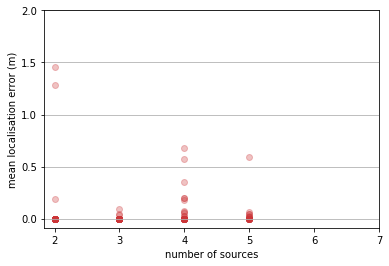

In [490]:
# Scatter Plot
x = pd.to_numeric(results['n_sources'].values)  # without to_numeric(), tikz_save() fails (TypeError: str instead of int)
y = results["err_mean"].values
plt.scatter(x, y, alpha=0.3, c=lms_red)
plt.xticks(n_sources_range)
adjust_y_axis(step_size=0.5, digits=2, min=0)
plt.grid(True, axis='y')
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
if EXPORT_LATEX:
    tikz_save(PATH_SCATTER_PLOT, show_info=False)

### Examine Outliers

In [491]:
print(results[results["err_mean"]>=1])

     err1   err2  err3  err4  err5  err_mean  err_total  n_sources  \
20  0.141  2.766   NaN   NaN   NaN     1.454      2.907          2   
22  2.571  0.000   NaN   NaN   NaN     1.285      2.571          2   

    perfect_match   x1  ...     y1  y1est   y2  y2est  y3  y3est  y4  y4est  \
20          False  2.1  ...    4.8    4.9  1.2    3.9 NaN    NaN NaN    NaN   
22          False  4.3  ...    4.7    2.2  1.7    1.7 NaN    NaN NaN    NaN   

    y5  y5est  
20 NaN    NaN  
22 NaN    NaN  

[2 rows x 29 columns]


## Compare Trials

In [492]:
files = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd*-dataframe.pkl'))
from pprint import pprint
print("The following files match the criterion:")
dfs = []
for f in files:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    version = fname[fname.find("rnd-")+4:fname.find("-dataframe")]
    if version=="": version="latest"
    df["version"] = version
    dfs.append(df)

try:   
    dfc = pd.concat(dfs, ignore_index=True)
except ValueError:
    import sys
    print("Concatination failed!\n{}".format(files), file=sys.stderr)

The following files match the criterion:
mean-err-n-sources-rnd-dataframe.pkl
mean-err-n-sources-rnd-v1-dataframe.pkl
mean-err-n-sources-rnd-v2-dataframe.pkl
mean-err-n-sources-rnd-v3-dataframe.pkl


### Mean error

version    latest     v1     v2     v3
n_sources                             
2           0.098  0.027  0.059  0.096
3           0.006  0.042  0.093  0.092
4           0.081  0.130  0.082  0.157
5           0.042  0.202  0.149  0.192
6             NaN  0.235  0.178    NaN
7             NaN  0.253  0.128    NaN


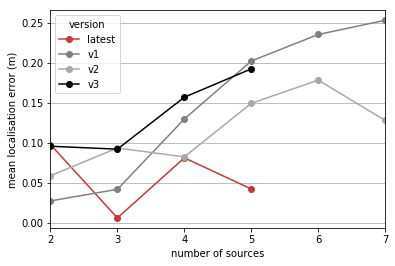

In [493]:
dfcp = dfc.pivot_table("err_mean", index="version", columns="n_sources", aggfunc='mean').transpose()
dfcp.plot(kind='line', marker='o', color=[lms_red, "gray", "darkgray", "black"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis="y")
print(dfcp)

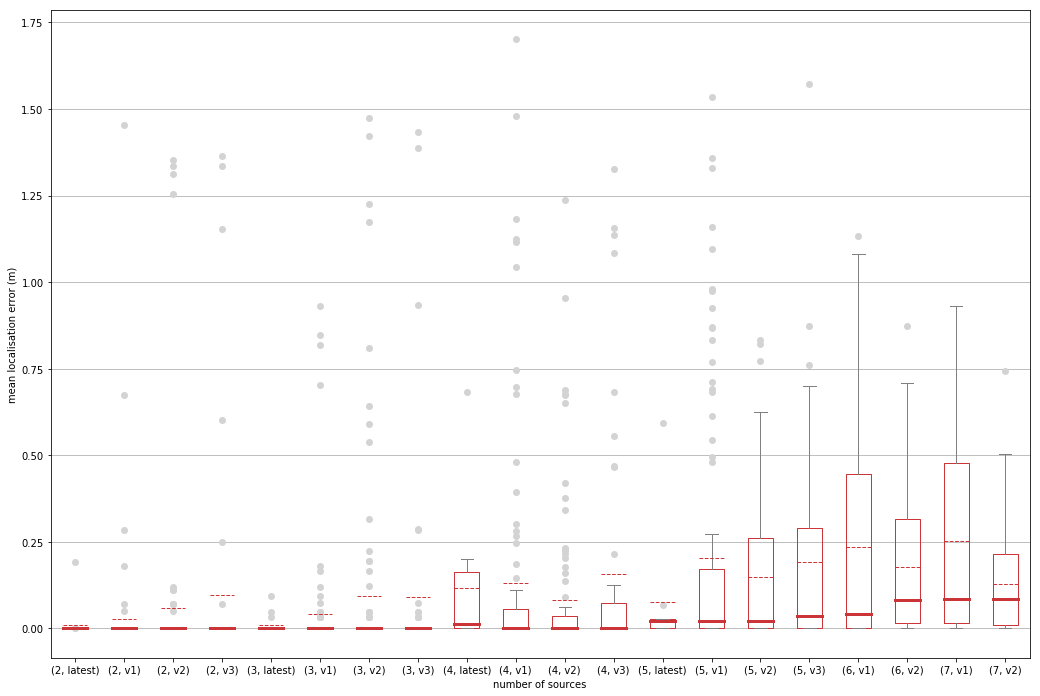

In [422]:
# Box Plot
bp = dfc.boxplot('err_mean', by=["n_sources", "version"], return_type='both', figsize=(17,  12), showmeans=True, meanline=True)
style_boxplot(bp)

if EXPORT_LATEX:
    tikz_save(PATH_BOX_PLOT, show_info=False)

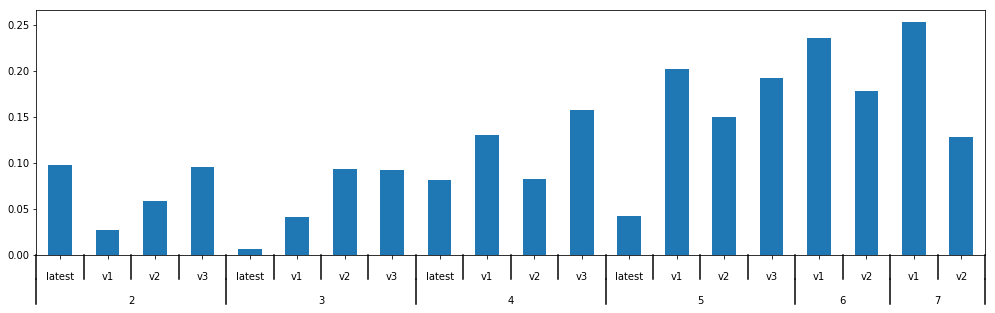

In [494]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby

def test_table():
    data_table = pd.DataFrame({'version':['v1']*4 + ['v2']*4,
                               'n_sources':(['2']*2 + ['3']*2)*2,
                               'Quantity':[10,20,5,6,4,7,2,1],
                               'Ordered':np.random.randint(0,10,8)
                               })
    return data_table

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

df = dfc.groupby(['n_sources','version']).mean()["err_mean"]
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(111)
df.plot(kind='bar',stacked=False,ax=fig.gca())
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)

### Perfect matches

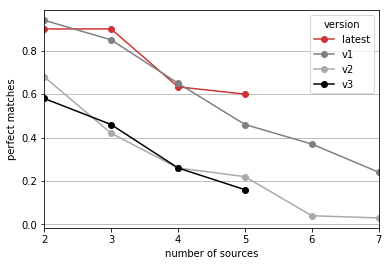

In [509]:
dfcp = dfc.pivot_table("perfect_match", index="version", columns="n_sources", aggfunc='mean').transpose()
dfcp.plot(kind='line', marker='o', color=[lms_red, "gray", "darkgray", "black"])
# Style plot
plt.xlabel("number of sources")
plt.ylabel("perfect matches")
plt.grid(axis="y")
# print(dfcp)

### Significance testing

DESCRIPTIVE ANALYSIS:
2 sources: n=100, min=0.000, max=1.453, mean=0.027, variance=0.026, std.dev=0.162
3 sources: n=100, min=0.000, max=0.930, mean=0.042, variance=0.027, std.dev=0.164
4 sources: n=100, min=0.000, max=1.701, mean=0.130, variance=0.108, std.dev=0.329
5 sources: n=100, min=0.000, max=1.535, mean=0.202, variance=0.132, std.dev=0.364
6 sources: n=100, min=0.000, max=1.133, mean=0.235, variance=0.108, std.dev=0.329
7 sources: n=100, min=0.000, max=0.931, mean=0.253, variance=0.091, std.dev=0.301

T-TEST FOR DIFFERENCE IN MEANS:
2x3: t=0.628, p=0.266 (n.s.)
2x4: t=2.797, p=0.003  ***  
3x4: t=2.396, p=0.009  ***  
3x5: t=4.025, p=0.000  ***  
4x5: t=1.479, p=0.070   *   
4x6: t=2.274, p=0.012   **  
5x6: t=0.677, p=0.250 (n.s.)
5x7: t=1.080, p=0.141 (n.s.)
6x7: t=0.400, p=0.345 (n.s.)

VISUALIZE MEANS AND VARIANCE OF DATA:


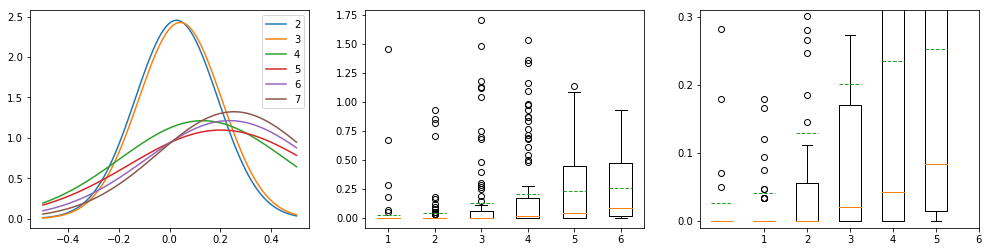

In [279]:
from scipy.stats import ttest_ind, describe, norm
from statsmodels.formula.api import ols

means = []
stddevs = []

fig, ax = plt.subplots(1,3, figsize=(17,  4))

# extract err_mean per n_sources
cat = {}
for n in n_sources_range:
    cat[str(n)] = results[results['n_sources']==n]['err_mean']

x = np.linspace(-0.5,0.5,100)
print("DESCRIPTIVE ANALYSIS:")
for n, c in cat.items():
    dr = describe(c)
    means.append(dr.mean)
    stddevs.append(np.sqrt(dr.variance))
    y = norm.pdf(x, loc=dr.mean, scale=np.sqrt(dr.variance))    # for example
    plt.subplot(131)
    plt.plot(x, y, label=n)  # plot gaussian
    print("{} sources: n={:3}, min={:0.3f}, max={:0.3f}, mean={:0.3f}, variance={:0.3f}, std.dev={:0.3f}".format(
        n, dr.nobs, dr.minmax[0], dr.minmax[1], dr.mean, dr.variance, np.sqrt(dr.variance)))
plt.legend()

plt.subplot(132)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)

plt.subplot(133)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)
plt.ylim(-0.01, 0.31)
plt.yticks([0, 0.1, 0.2, 0.3])
# plt.plot([n_sources_range, n_sources_range], [means, stddevs], marker="o")  # plot mean
# plt.title("Means")
# plt.plot()
# plt.subplot(133)
# plt.plot(stddevs)  # plot variance

# This means that given p and t values from a two-tailed test, you would reject the null hypothesis 
# of a greater-than test when p/2 < alpha and t > 0, and of a less-than test when p/2 < alpha and t < 0.    

print("\nT-TEST FOR DIFFERENCE IN MEANS:")
for i1 in n_sources_range:
    for i2 in n_sources_range:
        if i1!=i2 and i2>i1 and i2<=i1+2:
            ttest = ttest_ind(cat[str(i2)], cat[str(i1)], equal_var=False)
            p_onesided = ttest.pvalue/2
            if p_onesided < 0.01:sign="***"
            elif p_onesided < 0.05: sign="**"
            elif p_onesided < 0.10: sign="*"
            else: sign="(n.s.)"
            print("{}x{}: t={t.statistic:0.3f}, p={p:0.3f} {s:^6}".format(i1, i2, t=ttest, p=p_onesided, s=sign))

print("\nVISUALIZE MEANS AND VARIANCE OF DATA:")

## Other

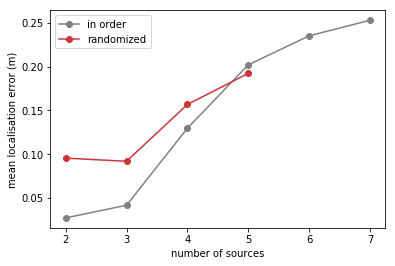

In [326]:
# Aggregate Data
dfpm = df.pivot_table("err_mean", columns="n_sources", aggfunc='mean').transpose()
df2pm = df2.pivot_table("err_mean", columns="n_sources", aggfunc='mean').transpose()

# Plot data
plt.plot(df2pm.index.values, df2pm.values, color='gray', label='in order', marker='o')
plt.plot(dfpm.index.values, dfpm.values, color=lms_red, label='randomized', marker='o')

# Style plot
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")

l = plt.legend()